In [1]:
import gym4real.envs.trading
import numpy as np
import matplotlib.pyplot as plt
from gym4real.envs.trading.utils import parameter_generator
import gymnasium as gym
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_vec_env
from sbx import PPO
from gym4real.algorithms.trading.utils import evaluate_agent_with_baselines
import random
import os

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ../..

/Users/giovannidispoto/Desktop/PhD/gym4ReaL_github/gym4ReaL


In [3]:
args = {
        'exp_name': 'trading/ppo',
        'n_episodes': 30,
        'n_envs': 6,
        'policy_kwargs': dict(net_arch=[512, 512]),
        'verbose': False,
        'gamma': 0.90,
        'learning_rate': 0.0001,
        'log_rate': 10,
        'batch_size': 236,
        'n_steps':  118*6,
        'ent_coeff': 0.,
        'save_model_as': 'ppo_sr_10_eps',
        'seeds': [1234, 5678, 91011]
    }

In [4]:
params_train = parameter_generator(world_options='gym4real/envs/trading/world_train.yaml')
params_validation = parameter_generator(world_options='gym4real/envs/trading/world_validation.yaml')
params_test = parameter_generator(world_options='gym4real/envs/trading/world_test.yaml')

env_bnh = gym.make(id="gym4real/TradingEnv-v0", **{'settings':params_train})
env_snh = gym.make(id="gym4real/TradingEnv-v0", **{'settings':params_train})


Training or Loading PPO agent

In [7]:
train = False

if train is True: #Train PPO
    for seed in args['seeds']:
        print("######## PPO is running... ########")
        
        train_env = make_vec_env("gym4real/TradingEnv-v0", n_envs=args['n_envs'], env_kwargs={'settings':params_train, 'seed': seed})
        eval_env = gym.make("gym4real/TradingEnv-v0", **{'settings':params_validation, 'scaler':train_env.env_method('get_scaler')[0]})
        
        logdir = "./gym4real/algorithms/trading/logs/" + args['exp_name']
        os.makedirs(logdir, exist_ok=True)
        
        eval_callback = EvalCallback(eval_env,
                                     best_model_save_path="./logs/{}/models/eval/".format(args['exp_name']+f"_seed_{seed}"),
                                     log_path="./logs/",
                                     eval_freq= (1 * train_env.env_method("get_trading_day_num")[0] * 118) / 2,
                                     n_eval_episodes=eval_env.unwrapped.get_trading_day_num(),
                                     deterministic=True,
                                     render=False)


        callbacks = [eval_callback]

        model = PPO("MlpPolicy",
                    env=train_env,
                    verbose=args['verbose'],
                    gamma=args['gamma'],
                    policy_kwargs=args['policy_kwargs'],
                    n_steps=args['n_steps'],
                    tensorboard_log="./gym4real/algorithms/trading/logs/tensorboard/trading/ppo/{}".format(args['exp_name']+f"_seed_{seed}"),
                    learning_rate=args['learning_rate'],
                    batch_size = args['batch_size'],
                    seed=seed
                    )

        model.learn(total_timesteps= args['n_episodes'] * train_env.env_method("get_trading_day_num")[0] * 598,
                    progress_bar=True,
                    log_interval=args['log_rate'],
                    tb_log_name="ppo_{}".format(args['exp_name']+f"_seed_{seed}"),
                    callback=callbacks,
                    reset_num_timesteps=True,)

        model.save("./logs/{}/models/{}".format(args['exp_name']+f"_seed_{seed}", args['save_model_as']))
        print("######## TRAINING is Done ########") 
else:
    train_env = make_vec_env("gym4real/TradingEnv-v0",  n_envs=args['n_envs'], env_kwargs={'settings':params_train} )
    eval_env = gym.make("gym4real/TradingEnv-v0", **{'settings':params_validation, 'scaler':train_env.env_method('get_scaler')[0]})
#Load Best PPO models
models = []
for seed in args['seeds']:
    model_folder = "./gym4real/algorithms/trading/logs/{}/models/".format(args['exp_name'] + f"_seed_{seed}")
    model = PPO.load(os.path.join(model_folder, "eval", "best_model"))
    models.append(model)
    

/Users/giovannidispoto/miniforge3/envs/gym4real/lib/python3.12/site-packages/gymnasium/envs/registration.py:736: UserWarning: WARN: The environment is being initialised with render_mode='rgb_array' that is not in the possible render_modes ([]).
  logger.warn(
/Users/giovannidispoto/miniforge3/envs/gym4real/lib/python3.12/site-packages/gymnasium/envs/registration.py:736: UserWarning: WARN: The environment is being initialised with render_mode='rgb_array' that is not in the possible render_modes ([]).
  logger.warn(
/Users/giovannidispoto/miniforge3/envs/gym4real/lib/python3.12/site-packages/gymnasium/envs/registration.py:736: UserWarning: WARN: The environment is being initialised with render_mode='rgb_array' that is not in the possible render_modes ([]).
  logger.warn(
/Users/giovannidispoto/miniforge3/envs/gym4real/lib/python3.12/site-packages/gymnasium/envs/registration.py:736: UserWarning: WARN: The environment is being initialised with render_mode='rgb_array' that is not in the pos

1
2
4
5
6
7
9
10
11
12
14
15
16
17
19
20
21
22
24
25
26
27
29
30
31
32
34
35
36
37
39
40
41
42
44
45
46
47
49
50
51
52
54
55
56
57
59
60
61
62
64
65
66
67
69
70
71
72
74
75
76
77
79
80
81
82
84
85
86
87
89
90
91
92
94
95
96
97
99
100
101
102
104
105
106
107
109
110
111
112
114
115
116
117
119
120
121
122
124
125
126
127
129
130
131
132
134
135
136
137
139
140
141
142
144
145
146
147
149
150
151
152
154
155
156
157
159
160
161
162
164
165
166
167
169
170
171
172
174
175
176
177
179
180
181
182
184
185
186
187
189
190
191
192
194
195
196
197
199
200
201
202
204
205
206
207
209
210
211
212
214
215
216
217
219
220
221
222
224
225
226
227
229
230
231
232
234
235
236
237
239
240
241
242
244
245
246
247
249
250
251
252
254
257
259
262
264
265
266
267
269
270
271
272
274
275
276
277
279
280
281
282
284
285
286
287
289
291
292
294
295
296
297
299
300
301
302
304
305
306
307
309
310
311
312
314
315
316
317
319
320
321
322
324
325
326
327
329
330
331
332
334
335
336
337
339
340
341
342
344
345
34

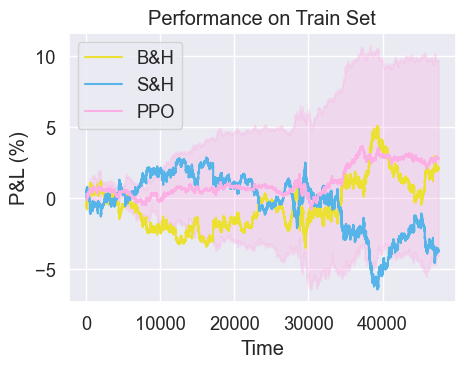

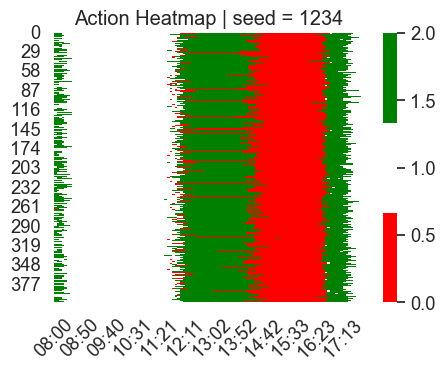

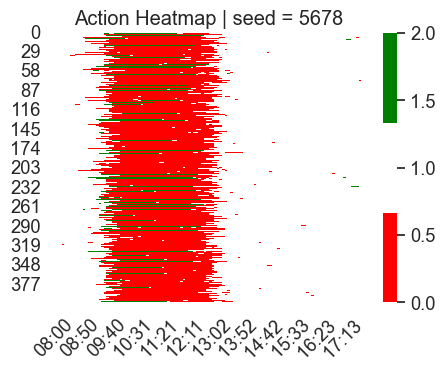

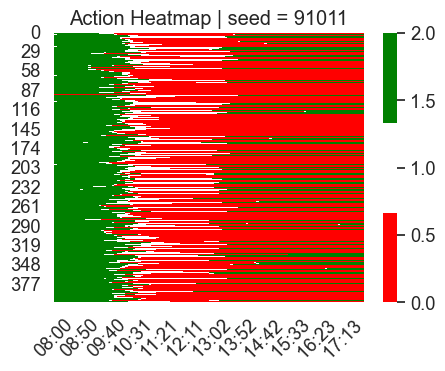

In [8]:
params_train['sequential'] = True
evaluate_agent_with_baselines(models, params_train, None, None, 'Train', args['seeds'], agent_name='PPO', show = True)

0
1
2
3
5
6
7
8
11
13
15
16
17
18
20
21
22
26
27
28
30
31
32
33
35
36
37
38
40
41
42
43
45
46
47
48
50
51
52
53
55
56
57
58
60
61
62
63
65
66
67
68
70
71
72
75
77
78
81
82
83
86
87
88
90
91
92
96
97
98
100
101
102
103
106
107
108
110
111
112
113
115
116
117
118
120
121
122
123
125
126
127
128
130
131
132
133
135
136
137
138
140
141
142
143
145
146
147
148
150
151
152
153
155
156
157
158
160
161
162
163
165
166
167
168
170
171
172
173
175
176
177
178
180
181
182
183
185
186
187
188
190
191
192
193
195
196
197
198
200
201
202
203
205
206
207
208
210
211
212
213
215
216
217
218
220
221
222
223
225
226
227
228
230
231
232
233
235
236
237
238
240
241
242
243
245
246
247
248
250
251
252
253
255
256
257
258
0
1
2
3
5
6
7
8
11
13
15
16
17
18
20
21
22
26
27
28
30
31
32
33
35
36
37
38
40
41
42
43
45
46
47
48
50
51
52
53
55
56
57
58
60
61
62
63
65
66
67
68
70
71
72
75
77
78
81
82
83
86
87
88
90
91
92
96
97
98
100
101
102
103
106
107
108
110
111
112
113
115
116
117
118
120
121
122
123
125
126
127


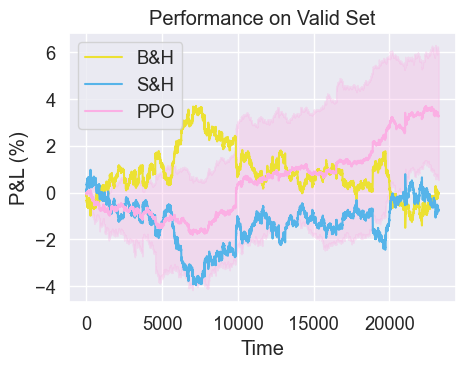

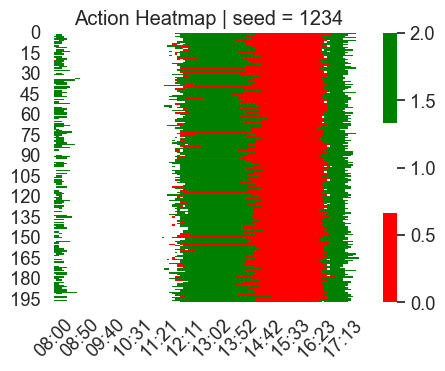

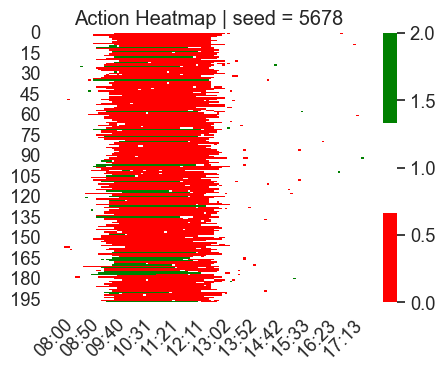

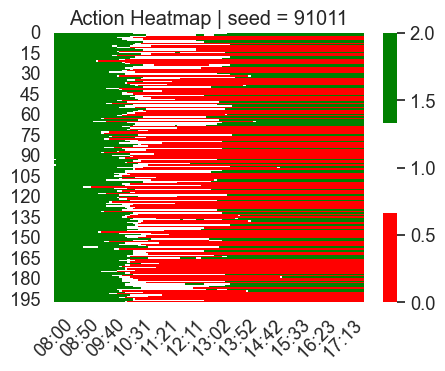

In [9]:
evaluate_agent_with_baselines(models, params_validation, None, train_env.env_method("get_scaler")[0], 'Valid', args['seeds'], agent_name='PPO', show = True,)

1
2
3
5
6
7
8
10
11
12
13
15
16
17
18
20
21
22
23
25
26
27
28
30
31
32
33
35
36
37
38
40
41
42
43
45
46
47
48
50
51
52
53
55
56
57
58
60
61
62
63
65
66
67
68
70
71
72
73
75
76
77
78
80
81
82
83
85
86
87
88
90
91
92
93
95
96
97
98
100
101
102
103
105
106
107
108
110
111
112
113
115
116
117
118
120
121
122
123
125
126
127
128
130
131
132
133
135
136
137
138
140
141
142
143
145
146
147
148
150
151
152
153
155
156
157
158
160
162
163
165
166
167
168
170
171
172
173
175
176
177
178
180
181
182
183
185
186
187
188
190
191
192
193
195
196
197
198
200
201
202
203
205
206
207
208
210
211
212
215
216
217
218
220
221
222
223
225
226
227
228
230
231
232
233
235
236
237
238
240
241
242
243
245
246
247
248
250
251
252
253
256
257
1
2
3
5
6
7
8
10
11
12
13
15
16
17
18
20
21
22
23
25
26
27
28
30
31
32
33
35
36
37
38
40
41
42
43
45
46
47
48
50
51
52
53
55
56
57
58
60
61
62
63
65
66
67
68
70
71
72
73
75
76
77
78
80
81
82
83
85
86
87
88
90
91
92
93
95
96
97
98
100
101
102
103
105
106
107
108
110
111
112


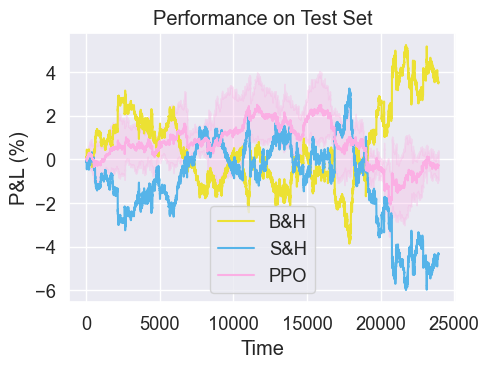

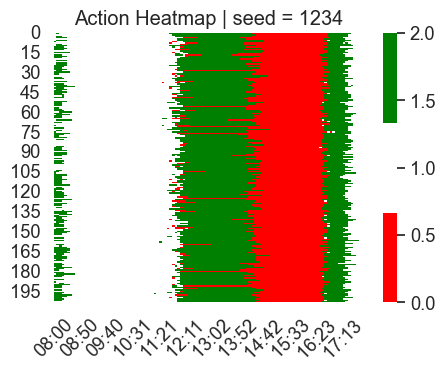

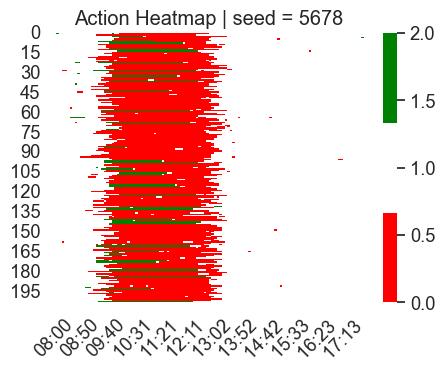

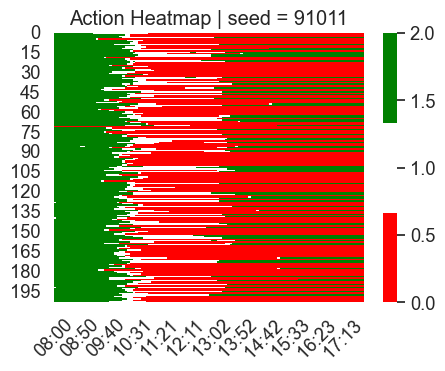

In [10]:
evaluate_agent_with_baselines(models, params_test, None, train_env.env_method("get_scaler")[0], 'Test', args['seeds'],agent_name='PPO', show = True)